### Property Encoding Scheme Comparison

After vectorizing objects and deciding on a structure for binding we need to determine how the fillers actually relate to the vectorized objects. Our filler space consists of actors, constant nouns, and verbs due to our assumed (agent, action, patient) structure, where all of these objects have an identity vector. A property also has an identity vector but cannot be used as a filler vector in itself. Currently only actors have properties (eg Steve is violent) but eventually we may as well add properties to constant nouns (eg the line is long) and verbs (eg she ran quickly).

The goal of a property encoding scheme is to determine how identity vectors and property vectors are related to create the filler vector for the object.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

% matplotlib inline

from sem_context import SemContext
import event_generation
import encoding_schemes
from event_schemas import BasicRNN
import hrr

Using TensorFlow backend.


### Helper Functions

Used in this demo to train and evaluate a RNN by generating events with a given encoding scheme. 

When generating a sequence of events, for each scene we generate we create a corresponding object that stores the fillers used to generate that scene. We train on sets of events and evaluate prediction performance after each set by generating evaluation events with a set of test actors that does not get seen in training. Each set can be trained as either a batch or online. 

When training on an event $E = [S_1, ..., S_n]$ we feed the neural network the input sequence $[enc(S_1), ..., enc(S_{n-1})]$ and the corresponding output sequence $[S_2, ..., S_n]$; the $enc()$ function represents the inclusion of property information. To understand this operation, consider observing the scene "Joe confronts Steve". When using it to predict the next scene, we may want to only encode certain properties of the actors (more on this later) that are relevant for prediction. However, in the previous scene when we're *predicting* "Joe confronts Steve", we only want to predict the (agent, action, patient) tuple and not the actual properties of the actors. Thus, all of the encoding schemes described are only used to encode scenes that we've already seen and that we are using for prediction; incoming scenes that we use to evaluate our predictions will all be encoded under the baseline encoding. 

In [2]:
# takes in set of events and returns encoded and decoded errors against generating fillers
def evaluate_predictions(encoding, events, fillers, context, testing = False):
    avg_encoded_error = 0.0
    avg_decoded_error = np.zeros(3)
    # traverse all evaluation events
    for e in range(len(events)):
        seen = [events[e][0]]
        encoded_error = 0.0
        decoded_error = np.zeros(3)
        # traverse all scene excluding the first
        for s in range(1, len(events[e])):
            prediction = hrr.normalize(transition_model.predict(seen))
            encoded_error += np.linalg.norm(encoding_schemes.fillers_to_baseline(fillers[e][s], context) - prediction)/(len(events[e]) - 1)
            decoded_error += np.asarray(encoding_schemes.filler_errors(encoding, prediction, fillers[e][s], context, testing))/(len(events[e]) - 1)
            seen.append(events[e][s])
        avg_encoded_error += encoded_error
        avg_decoded_error += decoded_error
    return [avg_encoded_error/len(events), avg_decoded_error/len(events)]

In [3]:
# train on set of events split into segments, evaluate after each segment
def train_online(context, encoding, segment_size, num_segments, eval_size, transition_model):
    errors = {}
    decoded_errors = []
    encoded_errors = []
    for segment in range(num_segments):
        # generate evaluation set and calculate evaluation error 
        testing, testing_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = eval_size, testing = True)
        testing_errors = evaluate_predictions(encoding, testing, testing_fillers, context, testing = True)
        encoded_errors.append(testing_errors[0])
        decoded_errors.append(testing_errors[1])
        # generate training set and train online for each event
        training, training_fillers = event_generation.generate_evaluation_events(context, encoding, num_events = segment_size, testing = False)
        for e in range(len(training)):
            X = np.asarray([training[e][0:len(training[e]) - 1]])
            Y = np.asarray([list(map(lambda x: encoding_schemes.fillers_to_baseline(training_fillers[e][x], context), range(1, len(training[e]))))])
            transition_model.model.fit(X, Y, verbose=0)
    errors['decoded_errors'] = np.asarray(decoded_errors)
    errors['encoded_errors'] = np.asarray(encoded_errors)
    return errors

In [29]:
# plot encoded and decoded errors
def plot_errors(encoding, errors):
    num = len(errors['encoded_errors'])
    plt.subplot(2, 1, 1)
    plt.plot(range(num), errors['encoded_errors'])
    plt.title(encoding + " encoded error")
    plt.xlabel("training segment")
    plt.ylabel("average event rmse")
    plt.subplot(2, 1, 2)
    plt.plot(range(num), list(map(lambda x : 1 - x, errors['decoded_errors'][:,0])), label = "agent")
    plt.plot(range(num), list(map(lambda x : 1 - x, errors['decoded_errors'][:,1])), label = "action")
    plt.plot(range(num), list(map(lambda x : 1 - x, errors['decoded_errors'][:,2])), label = "patient")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(encoding + " decoded error")
    plt.xlabel("training segment")
    plt.ylabel("average event filler error")
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()

### Setup

We define the SEM Context, which represents our environment by storing the identity vector for each object as well as a list of properties for each filler. We define the architecture of the event schema RNN using a list of layers that we later use to instantiate the RNN. We finally define parameters for the training and evaluation process.

In [5]:
dim = 50
nouns = ['coffeeshop', 'coffee', 'line', 'store', 'shirt', 'mall']
verbs = ['enter', 'obey', 'cut', 'buy', 'confront', 'hit', 'apologize', 'leave', 'greet', 'try']
properties = ['thirsty', 'violent', 'impatient', 'rich']
context = SemContext(dim, nouns, verbs, properties, num_train_actors = 30, num_test_actors = 10)

layers = [(50, 'sigmoid'), (dim, 'linear')]

segment_size = 20
eval_size = 150
num_segments = 201

### Baseline Model

In the baseline model we don't encode property information for any objects, so the filler vector for an object is just that object's identity vector. We expect bad testing error on this scheme because given just the identity vector of an actor we haven't seen before, we have no way of knowing how they will act in certain situations, reflecting the fact that in our generating model actor properties the branch probabilities. 

The scene "Joe confronts Steve" becomes $Role_{Agent} \otimes Id_{Joe} + Role_{Action} \otimes Confront + Role_{Patient} \otimes Id_{Steve}$.

In [6]:
transition_model = BasicRNN(dim, layers = layers)
baseline_errors = train_online(context, 'baseline', segment_size, num_segments, eval_size, transition_model)

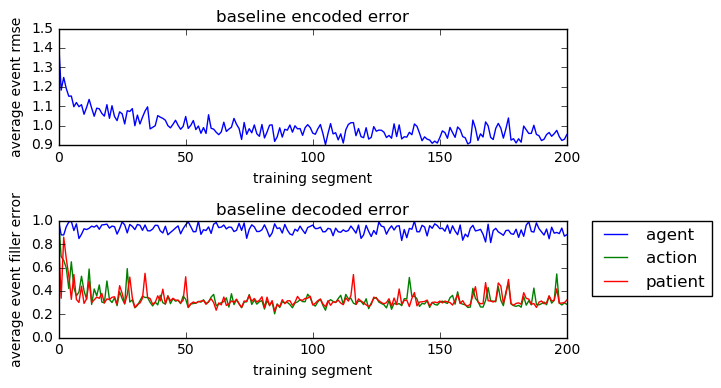

In [30]:
plot_errors("baseline", baseline_errors)

### Selective Addition

The selective addition model only encodes properties that are relevant in determining the next scene, where the filler vector for an actor is the sum of the actor's identity with their relevant property vectors. This encoding assumes that we already know the relevant properties for each prediction (the very thing we're trying to learn!) so it is not feasible in practice; we use it as an ideal benchmark to evaluate the realistic encoding schemes listed below. 

The scene "Joe confronts Steve" becomes 

$Role_{Agent} \otimes Props_{Joe} + Role_{Action} \otimes Confront + Role_{Patient} \otimes Props_{Steve}$

where

$Props_{Joe} = Id_{Joe} + Intimidating$ 

$Props_{Steve} = Id_{Steve} + Violent_{NOT}$

In [8]:
transition_model = BasicRNN(dim, layers = layers)
selective_property_addition_errors = train_online(context, 'selective_property_addition', segment_size, num_segments, eval_size, transition_model)

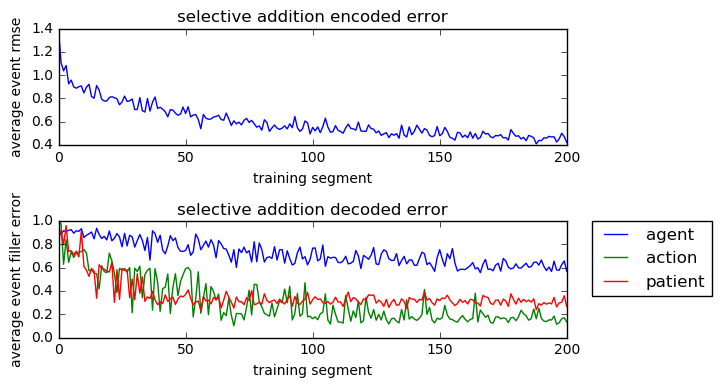

In [31]:
plot_errors("selective addition", selective_property_addition_errors)

### All Addition

To ensure that we aren't ignoring any property information that may be relevant for prediction, we encode all properties for each actor. One issue with this encoding is that we will encode a lot of unnecessary properties; for instance whether Joe is thirsty does not matter in determining whether Steve hits Joe after the confrontation, but we don't that a priori so we need to encode it. In a context with a lot of properties this may revert to baseline performance because encoding a large number of irrelevant properties causes a large percentage of the relevant information to be lost due to the noisy nature of the HRR, reflecting the brain's inability to focus on every detail of an actor when inferring causation. 

The scene "Joe confronts Steve" becomes $Role_{Agent} \otimes Props_{Joe} + Role_{Action} \otimes Confront + Role_{Patient} \otimes Props_{Steve}$

where 

$Props_{Joe} = Id_{Joe} + Thirsty_{NOT} + Sleepy_{NOT} + Intimidating + Violent$ 

$Props_{Steve} = Id_{Steve} + Thirsty + Sleepy_{NOT} + Intimidating_{NOT} + Violent$

In [10]:
transition_model = BasicRNN(dim, layers = layers)
all_property_addition_errors = train_online(context, 'all_property_addition', segment_size, num_segments, eval_size, transition_model)

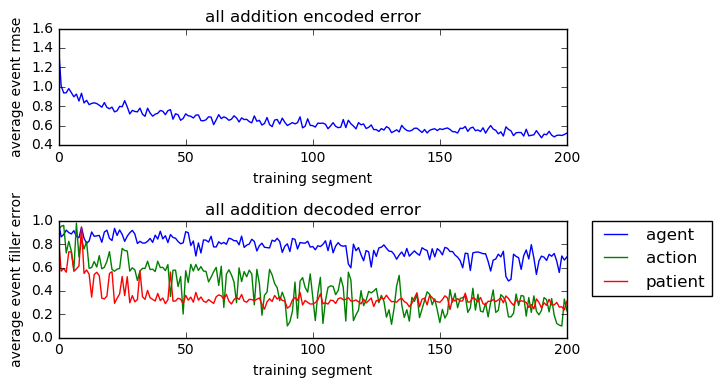

In [32]:
plot_errors("all addition", all_property_addition_errors)

### Bayesian Addition

This is an initial attempt to model the effects of attention on property selection using inference. Training involves observing a sequence of scenes, and while we are learning the world dyanmics we can simultaneously get an idea of what properties are relevant for each prediction, and only encode those. 

We assign a $Beta(1, 1)$ distribution to each (action A, role R, property P) tuple as a prior for the probability that upon oberving action A, property P of role R is relevant in predicting the next scene. When comparing the actual action to the predicted action, we update the distribution of the selected properties using the Beta Bernoulli conjugacy. 

As this is a preliminary attempt at this type of modeling, there are many considerations that need to be ironed out.

-The probability of obtaining a correct prediction will change over time, so the Beta Bernoulli model is not a perfect approximation for the selection of properties.

-If we train on all properties first to get a reasonable level of prediction before introducing the inference process, we find that all properties are encoded for deterministic events that are easy to predict (eg after seeing somebody buy coffee they will always leave the coffeeshop) and that properties are often conflated with each other.

In [12]:
def action_from_filler(context, filler):
    match = filler['action']['identity']
    for verb in context.verbs.keys():
        if list(context.verbs[verb]['identity']) == list(match):
            return verb
    
# 
def bayesian_update(encoding, event, fillers, used_property_list, context):
    seen = [event[0]]
    # traverse all scenes excluding the first
    for s in range(1, len(event)):
        prediction = hrr.normalize(transition_model.predict(seen))
        decoded_error = np.asarray(encoding_schemes.filler_errors(encoding, prediction, fillers[s], context, True))
        # update beta distributions using indicator of correct action prediction as bernoulli likelihood 
        for prop in used_property_list[s - 1]['subject']:
            context.distribution_params[action_from_filler(context, fillers[s - 1])]['subject'][prop][0] += (decoded_error[1])
            context.distribution_params[action_from_filler(context, fillers[s - 1])]['subject'][prop][1] += (1 - decoded_error[1])
        for prop in used_property_list[s - 1]['object']:
            context.distribution_params[action_from_filler(context, fillers[s - 1])]['object'][prop][0] += (decoded_error[1])
            context.distribution_params[action_from_filler(context, fillers[s - 1])]['object'][prop][1] += (1 - decoded_error[1])
        seen.append(event[s])

In [13]:
test_encoded_errors = []
test_decoded_errors = []

# the process should be: exist evaluate steps to get errors (only for graphing) and train step to actually train... thus instead of train and evaluate etc just 

# takes set of events and return encoded and decoded errors against generating fillers
def train_bayesian(context, encoding, segment_size, num_segments, eval_size, transition_model):
    errors = {}
    decoded_errors = []
    encoded_errors = []
    for segment in range(num_segments):
        # evaluate
        testing, testing_fillers, testing_chosen_properties = event_generation.generate_evaluation_events(context, encoding, num_events = eval_size, testing = True)
        testing_errors = evaluate_predictions(encoding, testing, testing_fillers, context, testing = True)
        encoded_errors.append(testing_errors[0])
        decoded_errors.append(testing_errors[1])
        # train
        training, training_fillers, chosen_properties = event_generation.generate_evaluation_events(context, encoding, num_events = segment_size, testing = False)
        for e in range(len(training)):
            seen = [hrr.normalize(training[e][0])]
            X = np.asarray([training[e][0:len(training[e]) - 1]])
            Y = np.asarray([list(map(lambda x: encoding_schemes.fillers_to_baseline(training_fillers[e][x], context), range(1, len(training[e]))))])
            transition_model.model.fit(X, Y, verbose=0)
            #transition_model.train_recurrent(list(map(lambda x : hrr.normalize(x), training[e])))
            bayesian_update(encoding, training[e], training_fillers[e], chosen_properties[e], context)
    errors['decoded_errors'] = np.asarray(decoded_errors)
    errors['encoded_errors'] = np.asarray(encoded_errors)
    return errors

In [14]:
dists = {}
for action in context.verbs.keys():
    dists[action] = {}
    dists[action]['subject'] = {}
    dists[action]['object'] = {}
    for prop in context.properties.keys():
        dists[action]['subject'][prop] = [1.0, 1.0]
        dists[action]['object'][prop] = [1.0, 1.0]
context.set_distribution_params(dists)

In [15]:
transition_model = BasicRNN(dim, layers = layers)
bayesian_addition_errors = train_bayesian(context, 'bayesian_property_addition', segment_size, num_segments, eval_size, transition_model)
#bayesian_addition_errors = train_online(context, 'all_property_addition', segment_size, 100, eval_size, transition_model)
#bayesian_addition_errors_append = train_bayesian(context, 'bayesian_property_addition', segment_size, 101, eval_size, transition_model)

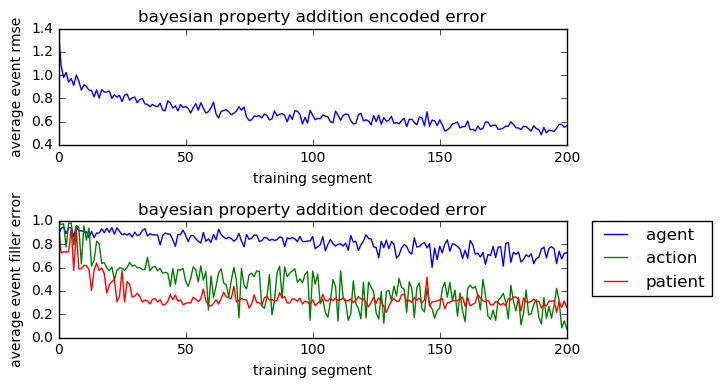

In [33]:
plot_errors("bayesian property addition", bayesian_addition_errors)

In [17]:
context.distribution_params

{'apologize': {'object': {'impatient': [63.0, 35.0],
   'rich': [58.0, 32.0],
   'thirsty': [50.0, 33.0],
   'violent': [59.0, 49.0]},
  'subject': {'impatient': [29.0, 30.0],
   'rich': [58.0, 39.0],
   'thirsty': [68.0, 37.0],
   'violent': [68.0, 30.0]}},
 'buy': {'object': {'impatient': [1.0, 1.0],
   'rich': [1.0, 1.0],
   'thirsty': [1.0, 1.0],
   'violent': [1.0, 1.0]},
  'subject': {'impatient': [238.0, 334.0],
   'rich': [240.0, 303.0],
   'thirsty': [232.0, 311.0],
   'violent': [257.0, 317.0]}},
 'confront': {'object': {'impatient': [198.0, 140.0],
   'rich': [161.0, 127.0],
   'thirsty': [190.0, 137.0],
   'violent': [214.0, 118.0]},
  'subject': {'impatient': [233.0, 122.0],
   'rich': [202.0, 122.0],
   'thirsty': [190.0, 136.0],
   'violent': [172.0, 104.0]}},
 'cut': {'object': {'impatient': [435.0, 349.0],
   'rich': [340.0, 286.0],
   'thirsty': [300.0, 250.0],
   'violent': [319.0, 286.0]},
  'subject': {'impatient': [327.0, 296.0],
   'rich': [361.0, 310.0],
   'thi

### Comparison

To compare encoding schemes we train and test a recurrent neural network on events generated from the different schemes. In this comparison we perform online training.

To get the encoded error (the error of the predicted vector) we define the event RMSE to be the average RMSE across all predicted scenes in the event, and we average event RMSE across all events in the evaluation set to get a measure of prediction error which we plot after each training iteration. 

To get the decoded error (which represents whether we predicted a filler correctly) given a role, we decode the prediction with that role's vector to get a prediction of the filler. We find the object in our filler space closest to the predicted filler using cosine similarity, and compare this to the actual filler used to generate the scene to get a 0-1 filler loss for an event. We get filler losses for agent, action, and patient. Once again we average these errors within each event to get event filler loss which we then average across all events in the evaluation set. 

It appears that the addition improvements in encoded error come from increased subject decodability, a counterintuitive result since the improvements afforded from the encoding should in theory be action related; predicting subjects and objects is a matter of role-filler learning rather than the learning of event dynamics. This is something I'm currently investigating. 

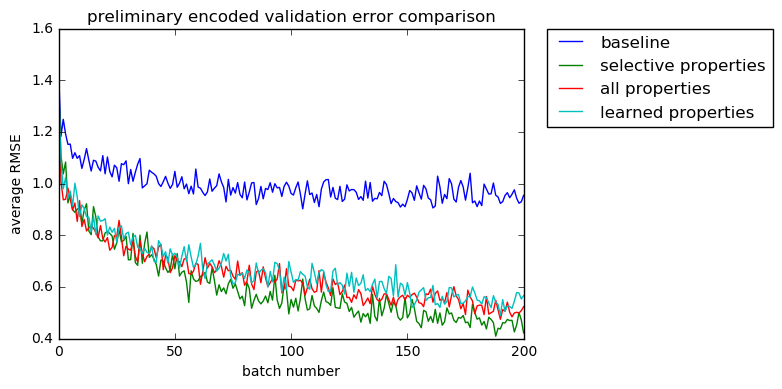

In [28]:
plt.plot(range(num_segments), baseline_errors['encoded_errors'], label = "baseline")
plt.plot(range(num_segments), selective_property_addition_errors['encoded_errors'], label = "selective properties")
plt.plot(range(num_segments), all_property_addition_errors['encoded_errors'], label = "all properties")
plt.plot(range(num_segments), bayesian_addition_errors['encoded_errors'], label = "learned properties")
plt.legend()
plt.title("preliminary encoded validation error comparison")
plt.xlabel("batch number")
plt.ylabel("average RMSE")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

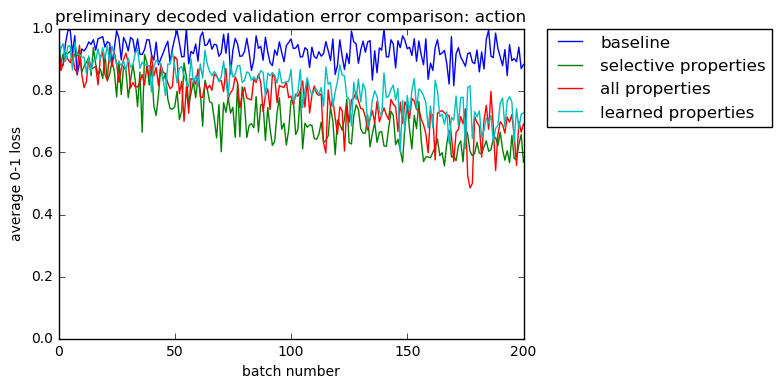

In [27]:
plt.plot(range(num_segments), list(map(lambda x : 1 - x, baseline_errors['decoded_errors'][:,0])), label = "baseline")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, selective_property_addition_errors['decoded_errors'][:,0])), label = "selective properties")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, all_property_addition_errors['decoded_errors'][:,0])), label = "all properties")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, bayesian_addition_errors['decoded_errors'][:,0])), label = "learned properties")
plt.title("preliminary decoded validation error comparison: agent")
plt.xlabel("batch number")
plt.ylabel("average 0-1 loss")
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

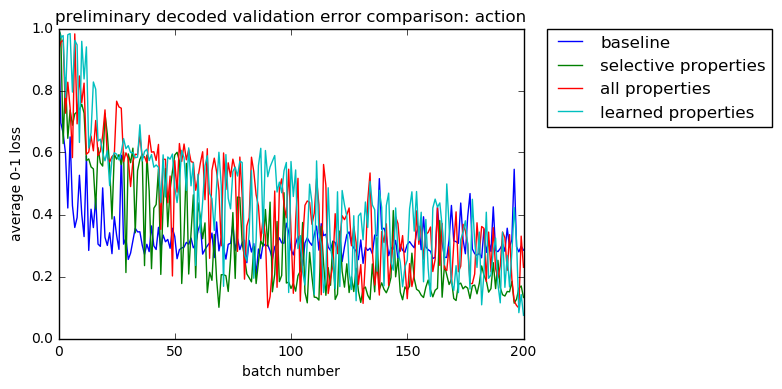

In [36]:
plt.plot(range(num_segments), list(map(lambda x : 1 - x, baseline_errors['decoded_errors'][:,1])), label = "baseline")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, selective_property_addition_errors['decoded_errors'][:,1])), label = "selective properties")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, all_property_addition_errors['decoded_errors'][:,1])), label = "all properties")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, bayesian_addition_errors['decoded_errors'][:,1])), label = "learned properties")
plt.title("preliminary decoded validation error comparison: action")
plt.xlabel("batch number")
plt.ylabel("average 0-1 loss")
plt.ylim([0, 1])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

(0, 1)

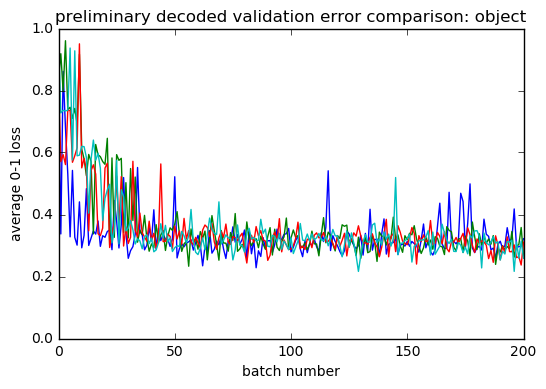

In [37]:
plt.plot(range(num_segments), list(map(lambda x : 1 - x, baseline_errors['decoded_errors'][:,2])), label = "baseline")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, selective_property_addition_errors['decoded_errors'][:,2])), label = "selective properties")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, all_property_addition_errors['decoded_errors'][:,2])), label = "all properties")
plt.plot(range(num_segments), list(map(lambda x : 1 - x, bayesian_addition_errors['decoded_errors'][:,2])), label = "learned properties")
plt.title("preliminary decoded validation error comparison: object")
plt.xlabel("batch number")
plt.ylabel("average 0-1 loss")
plt.ylim([0, 1])

### Current Goals

-Figure out alternatives to current method of attention modeling

-Try training with different loss functions, potentially some aggregate of decoded errors

-Look at how encoding performance relates to RNN architecture

-Move to coffee shop world

-Ensure scaling of the model to large actor, action, and property spaces

-Evaluate in SEM - use segmentation error to compare encoding schemes in addition to evaluation error in a single schema

-Learn probabilities in stochastic event generators